<center><h1>Projeto 3 - Ciência dos Dados </h1></center>
<center><h5>Alexandre Zamberlan Filho</h5></center>
<center><h5>Caio Horschutz Fauza</h5></center>
<center><h5>Pedro Paulo Mendonça Telho</h5></center>
 

> <b>Tema:</b> Previsão da modalidade esportiva que um atleta, baseando-se em características pré-definidas, deve praticar.        
><b>Metodologia:</b> Clusterização   
><b>Dataset utilizado:</b> "120 years of Olympic History of athletes and results" (Kaggle) 

# Parte 1: Coleta e Desenvolvimento dos dados

### 1.1 : Leitura do dataset "120 years of Olympic History of athletes and results"

In [1]:
import pandas as pd
import numpy as np
from sklearn import cluster, datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

geral = pd.read_csv("athlete_events.csv")
geral.head()


,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


### 1.2: Análise primária baseadas nos dados

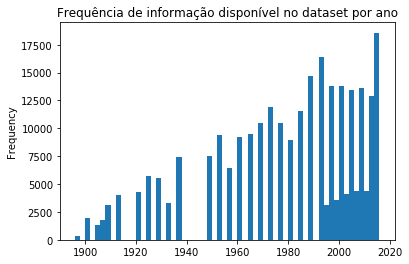

In [49]:
geral["Year"].plot.hist(title = "Frequência de informação disponível no dataset por ano", bins=60)

In [3]:
sports  = pd.unique(geral["Sport"]).tolist()
versions = pd.unique(geral["Games"]).tolist()
citys = pd.unique(geral["City"]).tolist()

print("Quantidade de modalidades disponíveis no dataframe: " + str(len(sports)))
print("Quantidade de versões dos jogos olímpicos disponíveis no dataframe: " + str(len(versions)))
print("Quantidade de cidades sedes dos jogos olímpicos disponíveis no dataframe (Verão + Inverno): " + str(len(citys)))

Quantidade de modalidades disponíveis no dataframe: 66
Quantidade de versões dos jogos olímpicos disponíveis no dataframe: 51
Quantidade de cidades sedes dos jogos olímpicos disponíveis no dataframe (Verão + Inverno): 42


Média de peso dos atletas: 70.70239290053351


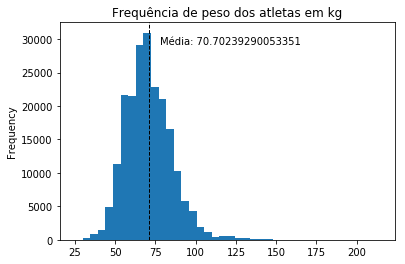

In [31]:
geral["Weight"].plot.hist(title = "Frequência de peso dos atletas em kg", bins=40)

plt.axvline(geral["Weight"].mean(), color='k', linestyle='dashed', linewidth=1)

_, max_ = plt.ylim()

plt.text(geral["Weight"].mean() + geral["Weight"].mean()/10, max_ - max_/10, 'Média: {}'.format(geral["Weight"].mean()))

print("Média de peso dos atletas: " + str(np.mean(geral["Weight"])))

É notavel assimetria nos dados em relação ao peso dos atletas. Os índices de maiores frequências estão localizados entre 50 e 80 kg aproximadamente.

Média de altura dos atletas: 175.33896987366376


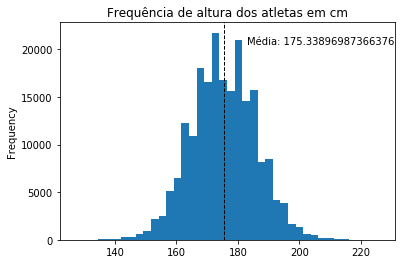

In [46]:
geral["Height"].plot.hist(title = "Frequência de altura dos atletas em cm", bins=40)

plt.axvline(geral["Height"].mean(), color='k', linestyle='dashed', linewidth=1)

_, max_ = plt.ylim()

plt.text(geral["Height"].mean() + geral["Height"].mean()/23, max_ - max_/10, 'Média: {}'.format(geral["Height"].mean()))

print("Média de altura dos atletas: " + str(np.mean(geral["Height"])))

É possível definir uma pequena simetria, de pouco valor nos dados relacionados a altura. Os índices de maiores frequências estão localizados entre 1,7 m e 1,85m aproximadamente.

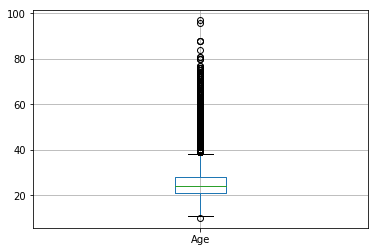

In [32]:
geral.loc[:,["Age"]].boxplot()

Média de idade dos atletas: 25.556898357297374


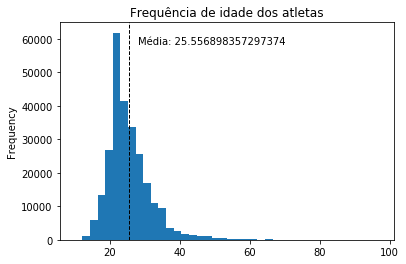

In [47]:
geral["Age"].plot.hist(title ="Frequência de idade dos atletas", bins=40)

plt.axvline(geral["Age"].mean(), color='k', linestyle='dashed', linewidth=1)

_, max_ = plt.ylim()

plt.text(geral["Age"].mean() + geral["Age"].mean()/10, max_ - max_/10, 'Média: {}'.format(geral["Age"].mean()))

print("Média de idade dos atletas: " + str(np.mean(geral["Age"])))

### 1.3 Análise da correlação entre os dados

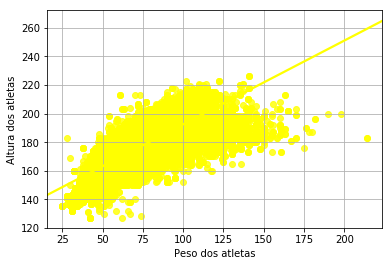

Índice de correlação (R) entre o peso e a altura dos atletas: 0.7962130921161656


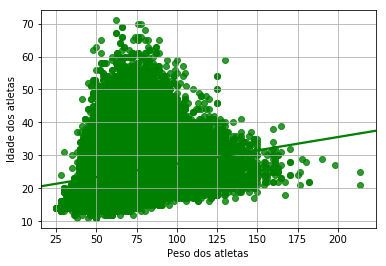

Índice de correlação (R) entre o peso e a idade dos atletas: 0.21206886474816442


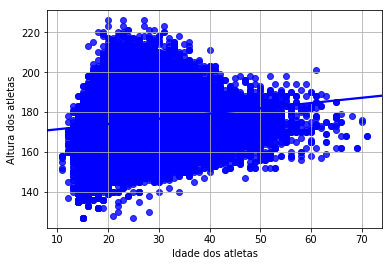

Índice de correlação (R) entre a idade a altura dos atletas: 0.13824647072838908


In [17]:
import numpy as np
import seaborn as sns

grafico1 = sns.regplot(geral['Weight'], geral['Height'], color='yellow');
plt.xlabel('Peso dos atletas')
plt.ylabel('Altura dos atletas')
plt.grid()
plt.show()
print('Índice de correlação (R) entre o peso e a altura dos atletas: '+str(geral.corr()['Weight']['Height']))

grafico2 = sns.regplot(geral['Weight'], geral['Age'], color='green');
plt.xlabel('Peso dos atletas')
plt.ylabel('Idade dos atletas')
plt.grid()
plt.show()
print('Índice de correlação (R) entre o peso e a idade dos atletas: '+str(geral.corr()['Weight']['Age']))

grafico3 = sns.regplot(geral['Age'], geral['Height'], color='blue');
plt.xlabel('Idade dos atletas')
plt.ylabel('Altura dos atletas')
plt.grid()
plt.show()
print('Índice de correlação (R) entre a idade a altura dos atletas: '+str(geral.corr()['Age']['Height']))

Entre as três análises pode-se perceber que entre peso e altura dos atletas há maior correlação. Esse índice nos indica o nível de dependência entre as variáveis e, portanto, nos mostra que essas duas variáveis são mais importantes se analisadas juntas.

### 2: Algorítimo

In [2]:
#MINIBATCHKMEANS
nclusters = 300 #len(geral["Sport"].value_counts())


geraldados = geral.loc[:,("Age", "Height", "Weight")]
geraldados2 = geraldados[geral.Season == "Summer"]
dados = geraldados2.dropna()

med = cluster.MiniBatchKMeans(n_clusters= nclusters, random_state = 0)

output = med.fit_predict(dados)
output

array([217, 295,  53, ..., 268,  71, 242])

In [3]:
#MINIBATCHKMEANS
grupos = pd.DataFrame(geral.Sport)
grupos['Grupo'] = pd.Series(output)
pd.crosstab(grupos.Sport, grupos.Grupo)
#MeanShift, DBSCAN, Spectral

Grupo,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,290.0,291.0,292.0,293.0,294.0,295.0,296.0,297.0,298.0,299.0
Sport,,,,,,,,,,,,,,,,,,,,,
Alpine Skiing,13,27,20,23,32,23,22,4,24,4,...,22,34,31,14,15,21,17,23,11,20
Alpinism,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
Archery,3,4,4,2,12,4,12,3,1,2,...,1,8,8,1,1,4,2,1,4,1
Art Competitions,5,14,7,11,14,4,10,2,9,8,...,11,17,9,1,5,6,8,4,10,2
Athletics,77,115,76,86,93,75,119,51,73,58,...,88,129,123,52,72,81,71,65,65,68
Badminton,1,3,2,8,3,0,4,3,2,4,...,2,2,2,4,2,4,4,5,4,7
Baseball,0,6,2,1,3,1,1,0,0,0,...,0,4,1,0,2,3,0,4,2,0
Basketball,12,19,14,10,6,6,7,4,11,10,...,12,10,17,8,9,15,5,7,7,11
Basque Pelota,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [49]:
#GaussianMixture
geraldados2 = geraldados[geral.Year >= 2000]
dados = geraldados2.dropna()

gm = cluster.AgglomerativeClustering(n_clusters = 20)



MemoryError: 

In [ ]:
#MeanShift
grupos = pd.DataFrame(geral.Sport)
grupos['Grupo'] = pd.Series(outputshift)
pd.crosstab(grupos.Sport, grupos.Grupo)

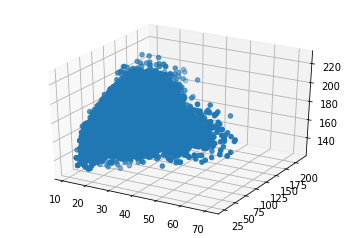

In [64]:

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

plt3d = plt.figure().gca(projection="3d")
plt3d.scatter(dados.Age, dados.Weight, dados.Height)

In [ ]:
#DBSCAN 

from sklearn.cluster import DBSCAN


geral = pd.read_csv("athlete_events.csv")

nclusters = len(geral["Sport"].value_counts())
sports = pd.unique(geral["Sport"]).tolist()

geraldados = geral.loc[:,("Age", "Height", "Weight")]
geraldados2 = geraldados[geral.Season == "Summer"]
dados = geraldados2.dropna()


med = cluster.DBSCAN(eps=5)
output = med.fit_predict(dados)


a = pd.Series(output)
a.value_counts()

grupos = pd.DataFrame(geral.Sport)
grupos['Grupo'] = pd.Series(output)
pd.crosstab(grupos.Sport, grupos.Grupo)